# 01. PyTorch Workflow

Exploring an example PyTorch end-to-end workflow.

## Overview:
1. Preparing and loading the data
2. Building the model
3. Fitting the model to data (training)
4. Making predictions and evaluating the model (inference)
5. Saving and loading the model
6. Putting it all together

In [2]:
import torch
from torch import nn # nn contains all of the building blocks for creating neural networks
import matplotlib.pyplot as plt
import numpy as np

torch.__version__

'2.2.0'

## 1. Preparing and loading the data

In machine learning data can be pretty much anything

* Excel spreadsheet
* Images
* Videos
* Text
* Audio
* DNA apparently!

It's all about turning data into a numerical representation and then building a model to learn patterns in that representation.

To showcase this, let's create some *known* data using the linear regression formula

In [3]:
# create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training and test sets (and eventually validation sets)

Let's create a training and test set with our data.
For now in a simple way, but there's a sklearn function that does it better.

In [4]:
# Create a train/test split
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Visualizing the data

Matplotlib my beloved <3

In [71]:
def plot_predictions(train_data=torch.Tensor.cpu(X_train), train_labels=torch.Tensor.cpu(y_train), test_data=torch.Tensor.cpu(X_test), test_labels=torch.Tensor.cpu(y_test), predictions=None):
    """
    Plots training data, test data and compares prediction
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
    if predictions is not None:
        # Plot them!
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

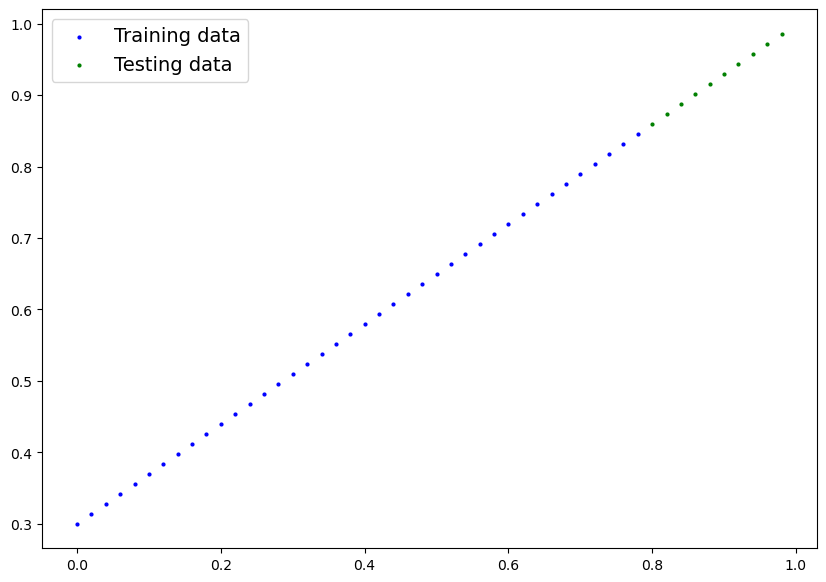

In [6]:
plot_predictions()

## 2. Building the model

What our model does:
* Start with random values (weight & bias here)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data in this example)

How does it do so?
Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [7]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                    requires_grad=True, # whether  this parameter can be changed via gradient descent
                                    dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                 requires_grad=True,
                                 dtype=torch.float))
        
    # Forward method to define the computation in th emodel
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weights * x + self.bias # linear regression formula

### PyTorch model buiding essentials

* torch.nn - contains all of the building blocks for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - optimization algorithms in PyTorch, they will help with gradient descent
* def forward() - all nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation, i.e. how the model makes predictions 

And more - https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside.

We can check our model parameters or what's inside our model using `.parameters()`.

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictions, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method.

`torch.inference_mode()` turns off PyTorch's gradient tracking, which is useful when we're not training our model (it doesn't have to calculate gradients when making predictions)

Old code might use `torch.no_grad()` instead, but it's slower.

In [10]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [11]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# This also works, but it's slower
# with torch.no_grad():
    # y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

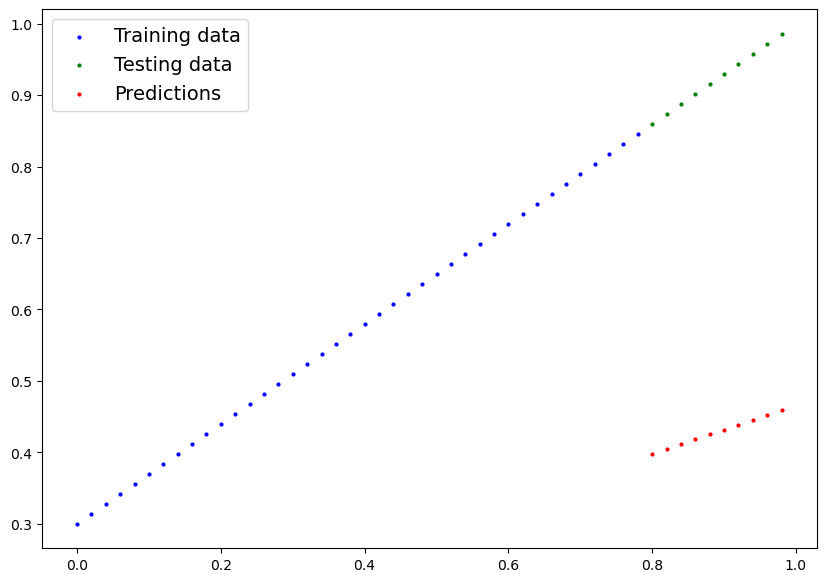

In [12]:
plot_predictions(predictions=y_preds)

## 3. Training the model

The whole idea of training is for a model to move from some *unknown* parameters (these might be random) to *known* parameters. 

In other words, from random weights and biases to weights and biases that are closer to the ideal values (from a poor representation of data to a better representation)

One way to measure how poor or how wrong the model's prediction are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our purposes, we'll use loss function.

Things we need to train:

* **Loss function:** A function that measures how far off a model's predictions are from its true values. The further away the predictions, the higher the loss.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (weights and biases) to reduce the loss.
    * Inside the optimizer we'll often have to set two parameters:
        * `params` - the model parameters we'd like to optimize, for example `params=model_0.parameters()`
        * `lr` (learning rate) - hyperparameter that defines how big/small are the changes of the model's parameters during optimization (small `lr` - small changes, big `lr` - big changes)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [13]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [14]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01) # <- learning rate, probably the most important hyperparameter you can set

#### Which loss function/optimizer should I use?

It depends on the problem.

For regression problems (for example predicting a number), the mean squared error (`nn.MSELoss`) or mean absolute error (`nn.L1Loss()`) loss function and an optimizer like stochastic gradient descent `torch.optim.SGD()` is often used.

For a classification problem (predicting whether something is one thing or another), the cross-entropy loss function (`nn.CrossEntropyLoss`) or binary cross-entropy (`nn.BCELoss`) is often used.

### Building a training loop (and testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass prediction to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate gradients of each of the parameters of our model with respect to the loss (also called backpropagation)
5. Optimizer step - use the optimizer to adjust our model's parameters to reduce the loss (gradient descent)

In [15]:
# An epoch is one loop through the data (this is a hyperparameter because we've set it ourselves)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# Training loop
# 0. Loop through the data
# Pass the data through the model for a number of epochs
for epoch in range(1, epochs+1):
    # Set the model to training mode
    model_0.train() # train mode in PyTorch sets the model to be able to update its parameters

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad() # zero the gradients of the model's parameters

    # 4. Backpropagation on the loss with respect to the model's parameters
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will accumulate (add on top of each other), so we need to zero the gradients each time

    ### Testing
    model_0.eval() # -> eval mode in PyTorch sets the model to only make predictions (no parameter updates)
    with torch.inference_mode(): # turns off gradients tracking & a couple more things behind the scenes
        # 1. Forward pass
        test_pred = model_0(X_test)

        # 2. Calculate loss
        test_loss = loss_fn(test_pred, y_test)
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Test loss: {test_loss:.4f}")

# Print out model state_dict()
print(model_0.state_dict())
        

Epoch: 10 | Loss: 0.2092 | Test loss: 0.3598
Epoch: 20 | Loss: 0.0968 | Test loss: 0.2282
Epoch: 30 | Loss: 0.0546 | Test loss: 0.1497
Epoch: 40 | Loss: 0.0459 | Test loss: 0.1154
Epoch: 50 | Loss: 0.0420 | Test loss: 0.1003
Epoch: 60 | Loss: 0.0385 | Test loss: 0.0893
Epoch: 70 | Loss: 0.0351 | Test loss: 0.0810
Epoch: 80 | Loss: 0.0317 | Test loss: 0.0734
Epoch: 90 | Loss: 0.0282 | Test loss: 0.0652
Epoch: 100 | Loss: 0.0248 | Test loss: 0.0569
Epoch: 110 | Loss: 0.0214 | Test loss: 0.0493
Epoch: 120 | Loss: 0.0179 | Test loss: 0.0410
Epoch: 130 | Loss: 0.0145 | Test loss: 0.0334
Epoch: 140 | Loss: 0.0111 | Test loss: 0.0252
Epoch: 150 | Loss: 0.0076 | Test loss: 0.0169
Epoch: 160 | Loss: 0.0042 | Test loss: 0.0093
Epoch: 170 | Loss: 0.0026 | Test loss: 0.0084
Epoch: 180 | Loss: 0.0026 | Test loss: 0.0084
Epoch: 190 | Loss: 0.0026 | Test loss: 0.0084
Epoch: 200 | Loss: 0.0026 | Test loss: 0.0084
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})


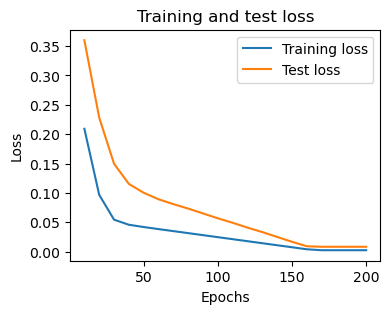

In [16]:
# Plot the loss curves
plt.figure(figsize=(4, 3))

plt.plot(epoch_count, loss_values, label="Training loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [17]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

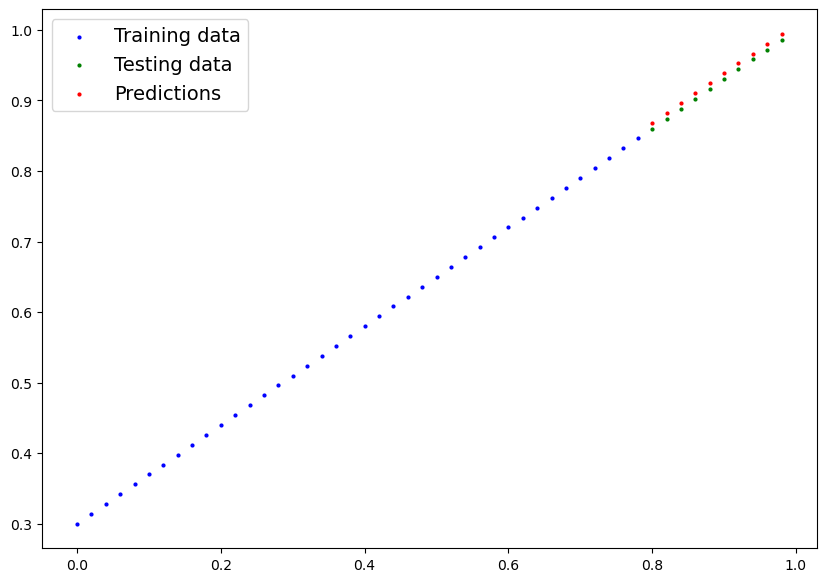

In [18]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# This also works, but it's slower
# with torch.no_grad():
    # y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

## 4. Saving a model in PyTorch

PyTorch files are usually saved in a `.pt` or `.pth` format.

There are three main methods for saving and loading models in PyTorch:

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows you to load a model's saved state dictionary

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [19]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [20]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models' directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model state dict to {MODEL_SAVE_PATH}...")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model state dict to models\01_model_0.pth...


## 5. Loading a PyTorch model

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [21]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will overwrite the parameters of loaded_model_0 with the saved ones)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [22]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [23]:
# Make predictions with loaded model
loaded_model_0.eval() # set to evaluation mode
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [24]:
model_0.eval()
with torch.inference_mode():
    model_0_preds = model_0(X_test)

model_0_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [25]:
model_0_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Revision

Also spicing things up a little bit with some more advanced PyTorch concepts.

Create device-agnostic code.

This means if we've got acces to a GPU, our code will use it (for potentially faster computing).

If no GPU is available, our code will use the CPU.

In [27]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

In [29]:
# Create some data using the linear regression formula y = weight * X + bias
weight = 3.7
bias = 2.1

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, X and y would be (50,) instead of (50, 1)
y = weight * X + bias

X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[2.1000],
         [2.1740],
         [2.2480],
         [2.3220],
         [2.3960]]))

In [30]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

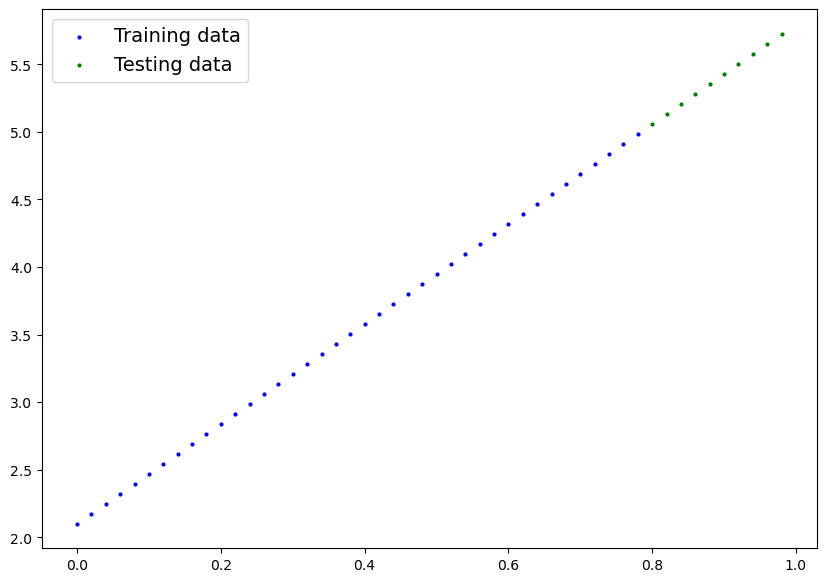

In [31]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch linear model

In [41]:
# Create a linear model by subclassing nn.Module

class LinearRegressionV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear = nn.Linear(in_features=1, out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)
    
# Set the random seed
torch.manual_seed(42)

# Create a model
model_1 = LinearRegressionV2()
model_1, model_1.state_dict()

(LinearRegressionV2(
   (linear): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear.weight', tensor([[0.7645]])),
              ('linear.bias', tensor([0.8300]))]))

In [42]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [43]:
# Set the model to use the target device
model_1.to(device)

LinearRegressionV2(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [44]:
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training code

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [48]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [52]:
# Let's write a training loop

# Set the number of epochs
epochs = 500

# Track the losses
epoch_losses = []
losses = []
train_losses = []

# PUT DATA ON THE RIGHT DEVICE!!! (device agnostic core for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(1, epochs+1):
    model_1.train() # set the model to training mode

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # set the model to evaluation mode
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        epoch_losses.append(epoch)
        losses.append(loss.item())
        train_losses.append(test_loss.item())
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Test loss: {test_loss:.4f}")


Epoch: 10 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 20 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 30 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 40 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 50 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 60 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 70 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 80 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 90 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 100 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 110 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 120 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 130 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 140 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 150 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 160 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 170 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 180 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 190 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 200 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 210 | Loss: 0.0034 | Test loss: 0.0128
Epoch: 220 | Loss: 0.0034 | Test loss: 0.01

In [53]:
model_1.state_dict()

OrderedDict([('linear.weight', tensor([[3.6906]], device='cuda:0')),
             ('linear.bias', tensor([2.0956], device='cuda:0'))])

### 6.4 Making and evaluating predictions

In [68]:
# Remember about eval and inference_mode for making predictions
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test)
torch.Tensor.cpu(y_preds)

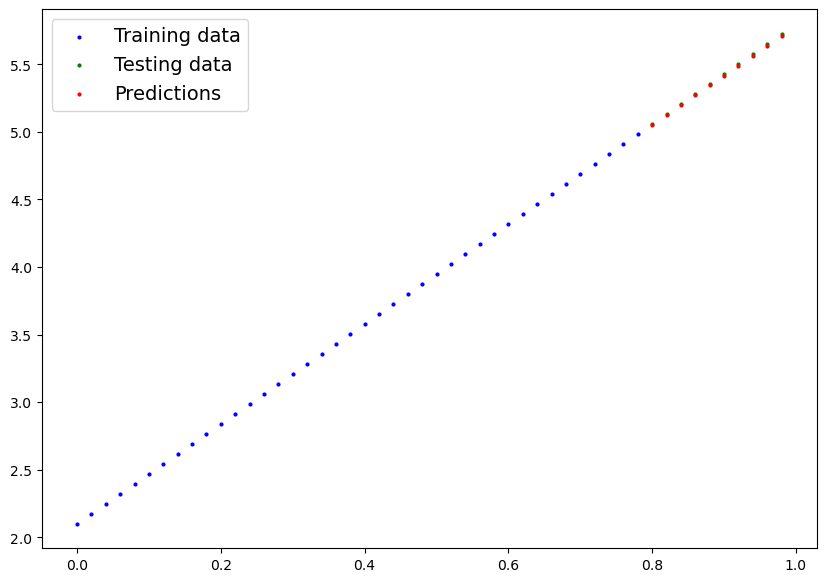

In [72]:
# Copy the results back to CPU for plotting!
plot_predictions(predictions=torch.Tensor.cpu(y_preds))

### 6.5 Saving & loading a model

In [73]:
from pathlib import Path

# Create path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create name
MODEL_NAME = "01_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model state dict to {MODEL_SAVE_PATH}...")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model state dict to models\01_model_1.pth...


In [74]:
# Loading the model

# Create a new instance of the model
loaded_model_1 = LinearRegressionV2()

# Load the saved model_1 state dict into the new model
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [75]:
loaded_model_1.state_dict()

OrderedDict([('linear.weight', tensor([[3.6906]])),
             ('linear.bias', tensor([2.0956]))])

In [76]:
# Loaded model is automatically put on cpu
next(loaded_model_1.parameters()).device

device(type='cpu')

In [78]:
# Put the loaded model on the same device as the original model
loaded_model_1.to(device)
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [81]:
# Evaluate the loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_preds = loaded_model_1(X_test)
y_preds == loaded_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')